# SI 618 Homework 6: Clustering

## The total score for this assignment will be 100 points, consisting of:
- 10 pt: Overall quality of spelling, grammar, puctuation, etc. of written sentences.
- 10 pt: Code is written in [PEP 8](https://www.python.org/dev/peps/pep-0008/) style.
- 80 pt: Homework questions. 

## Top-level Goal
Your overall goal in this assignment is to cluster airplane incidents according to the text contained in the summaries of the incidents.  This will provide an opportunity for you to apply the methods we talked about in the lecture. 

You should pick a decade (i.e. any contiguous 10-year span) of air crashes data, focus on the column called "summary" and try to cluster the air crashes based on these summaries using both hierarchical and k-means clustering.

Hint:
- Be careful with the choice of decade, some decades do not have sufficient data to play with.
- pandas.to_datetime is a useful function for transforming string-based dates to datetime objects in a dataframe.
- It's necessary to clean the data before you formally begin to answer the questions.

In [1]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc
%matplotlib inline
import pandas as pd
import seaborn as sns
import numpy as np
from collections import Counter
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
import itertools
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn import metrics
from wordcloud import WordCloud

# Q1 (5 points) Download and describe the data
You can download the air crash dataset through this [page](https://opendata.socrata.com/Government/Airplane-Crashes-and-Fatalities-Since-1908/q2te-8cvq). Download the .csv file (Airplane_Crashes_and_Fatalities_Since_1908.csv) and explore the dataset in the same way as you explored the Pokemon dataset in this week's class.  You should use graphical and analytic methods to describe the data as completely as possible.

In [2]:
df_plane = pd.read_csv('Airplane_Crashes_and_Fatalities_Since_1908.csv')
df_plane.sample(20)

,Date,Time,Location,Operator,Flight #,Route,Type,Registration,cn/In,Aboard,Fatalities,Ground,Summary
3081,10/03/1978,NaN,"Near Kuopio, Finland",Military - Finish Air Force,NaN,Kuopio - Helsinki,Douglas C-47A-1-DK,DO-10,12050,15.0,15.0,0.0,"After taking off, one of engines stalled due t..."
4295,11/01/1994,NaN,"Off Cozumel, Mexico",Transportes Aereos Pegaso,NaN,Cozumel - Chichen Itza,Bell 212,XA-SVS,30824,14.0,14.0,0.0,Crashed into the sea off of Cozumel while en r...
2592,09/30/1972,NaN,"Madrid, Spain",Spantax,NaN,Training,Douglas C-47B,EC-AQE,14196/25641,6.0,1.0,0.0,"The student pilot rotated too quickly, the pla..."
466,05/05/1938,NaN,"Balbuena, Mexico",Lineas Aéreas Mineras,NaN,Mexico City - Juarez,Lockheed Vega 5B,XA-BFR,124,6.0,1.0,0.0,Crashed en route
2923,09/09/1976,14:50,"Off Adler, Russia",Aeroflot / Aeroflot,7957 /31,Donetsk - Sochi /Rostov na Donu - Kerch,Antonov AN-24 / Yakovlev Yak-40,46518/87772,37308504 / 9030713,90.0,90.0,0.0,Midair collision at FL187. ATC error. Fifty-t...
61,04/08/1922,NaN,"Pao Ting Fou, China",NaN,NaN,NaN,NaN,NaN,NaN,17.0,17.0,0.0,All seventeen aboard were Chinese nationals.
3541,02/19/1985,10:15,"300 nm NW of San Francisco, California",China Airlines (Taiwan),006,Taipei - Los Angeles,Boeing B-747-SP-09,N4522V,22805/564,274.0,0.0,0.0,The aircraft descended in an uncontrolable div...
2885,03/07/1976,02:20,"San Onofre, California",Sky Haven - Air Taxi,NaN,"Palm Springs, CA - Santa Ana, CA",Cessna 172M,N1631V,NaN,2.0,2.0,0.0,The aircraft crashed into the PacifiOcean afte...
5030,01/13/2005,22:18,"Keene, New Hampshire",AirNow,NaN,"Bangor, ME - Concord, NH",Embraer EMB-110 Bandeirante,N49BA,110301,1.0,1.0,0.0,The cargo plane diverted to Keene due to poor ...
2309,04/24/1969,NaN,"Near Takoradi, Ghana",Ghana Airways,NaN,NaN,Douglas DC-3,9G-AAF,9407,33.0,1.0,0.0,The aircraft struck high ground after engine p...


In [3]:
df_plane_describe = df_plane.dropna().describe()
df_plane_describe

,Aboard,Fatalities,Ground
count,944.000000,944.000000,944.000000
mean,63.145127,44.498941,6.619703
std,71.398580,59.230520,126.649802
min,1.000000,0.000000,0.000000
25%,15.000000,7.000000,0.000000
50%,38.000000,21.500000,0.000000
75%,89.000000,62.000000,0.000000
max,644.000000,583.000000,2750.000000


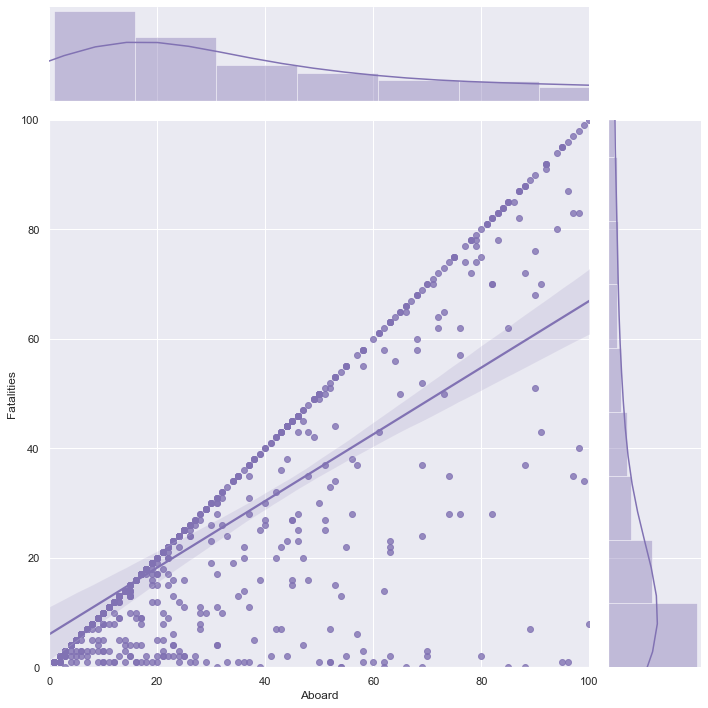

In [4]:
df_plane_clean = df_plane.dropna()
sns.set(style="darkgrid")


g = sns.jointplot("Aboard", "Fatalities", data= df_plane_clean,
                  kind="reg", truncate=False,
                  xlim=(0, 100), ylim=(0, 100),
                  color="m", height=10)


The sscatterplot in the jointplot above shows that as the flights aboard the fatalities increase. The datapoints are densely clustered at zero values. The regression line shows that thw two variables "Aboard" and "Fatalities are strongly correlated with some amount of standard deviation represented by the shaded area above and below the regression line. The histogram from the jointplot also shows that as the number of flights that aboard increase the number of fatalities also increase. The normal distribution curve is positively skewed.

C:\Users\tabas\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\tabas\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\tabas\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\tabas

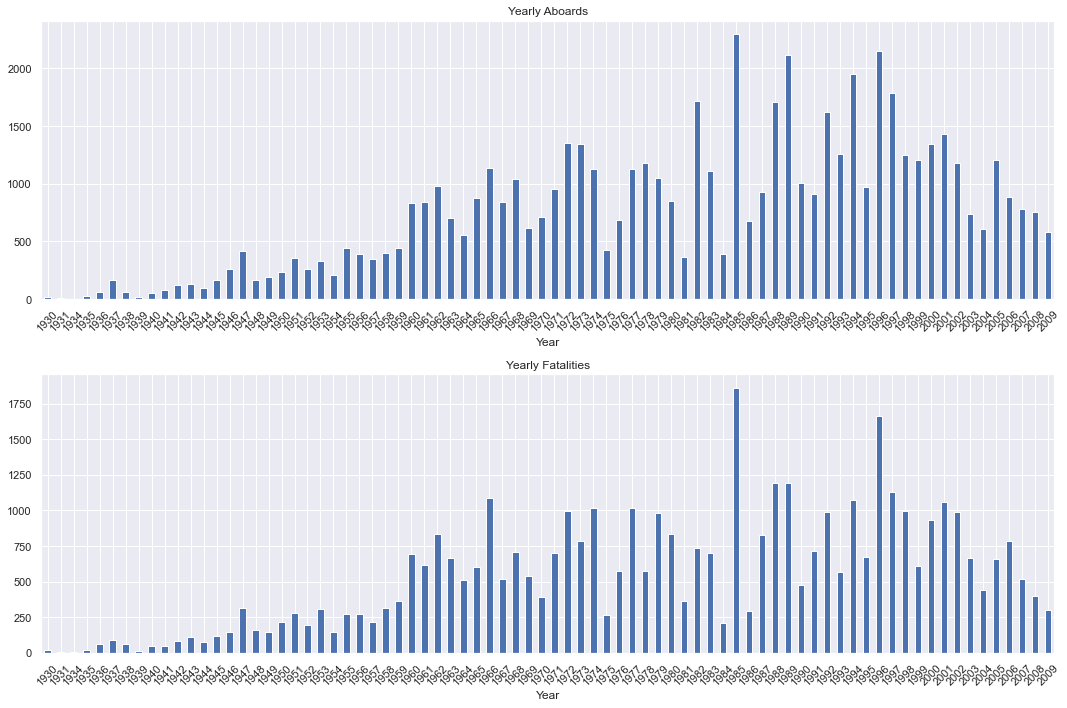

In [5]:
df_graph2 = df_plane_clean[['Date','Aboard','Fatalities']]
df_graph2['Year'] = df_graph2['Date'].apply(lambda x: int(str(x)[-4:]))
yy_dd = df_graph2[['Year','Aboard','Fatalities']].groupby('Year').agg(['count','sum'])
yy_graph,(axy1,axy2)=plt.subplots(2,1,figsize=(15,10))
yy_dd['Aboard','sum'].plot(kind='bar',title='Yearly Aboards',grid=True,ax=axy1,rot=45)
yy_dd['Fatalities','sum'].plot(kind='bar',title='Yearly Fatalities',grid=True,ax=axy2,rot=45)
plt.tight_layout()

The above bar graph shows that as the year increases the number of fatalities and aboards fairly increases. This shows that aboards and falatlities are quite strongly correlated. The year 1985 shows highest number of aboards and fatalities and the year 1930 shows the least.

# Q2 (10 pts): Create a roadmap to process the data
Think of how you will solve the problems in different steps.  What kind of data you need to prepare for clustering? How would you run clustering algorithms on the dataset?  Please write down your thoughts below and specify your expectations of the clustering results.

Road Map Followed:

-Formulating the Problem: The problem here is that the data on which the cluster analysis is to be performed is of the categorical form and is unclean i.e; requires text processing. The goal is to conduct hierarchial and k means clustering over meaningful words out of all the summaries.

-Selecting a Distance Measure: The data/ meaningful words from each summary are cleaned and seperated as frequency coloumns. This is achieved by text processing, i.e by removing special characters, repetitive/stop words and weird punctuation characters. Categorical data is convertd to numerical data.

-Selection of Clustering Procedure: Either hierarchial or k means clustering. It is important to select the number of clusters which is determined by elbow method, silhoutte method and rule of thumb method. 

-Interpreting and profiling the clusters: By rule of thumb obtain the maximum number or range of clusters from the data, which we then apply to the range of clusters obtained by rule of thumb and hence assess the validity of the clustering method by the help of Dendograms and Silhouette method. The value of k is obtained by Elbow method.


My expectations are to understand and analyse the number of clusters in the data, how closely are the clusters related to each other and figure out whether the data points are densely distributed. Primarly, we calculate the differences and similiarity between clusters in the data.

# Q3 (20 pts): Text processing
With each summary, we want to transform the text into a frequency vector. For example, if we have two summaries:
- "The plane was crashed with no alarms. Checking the plane."
- "The plane was crashed on a mountain. "

After some basic text processing such as lowercases and removing stop words, you can create a frequency dataframe like this:

![Frequency Table](freq_table.png)

Please transpose the dataframe (pandas.DataFrame.transpose) and represent each summary as a frequency vector:

![Freq Table T](freq_table_t.png)

We will calculate the similarity between the summaries and run clustering algorithms based on this frequency tables.

In [6]:
df_plane_copy = df_plane_clean.copy()
df_plane_summary = pd.DataFrame(df_plane_copy['Summary'])
df_plane_summary.rename(columns = {'Summary': 'summary'}, inplace = True)
df_plane_summary

,summary
208,"While en route to Los Angeles, the pilot, flyi..."
236,"Shortly after taking off from Kansas City, one..."
334,The plane crashed about 11 miles from St. Jose...
354,The plane crashed while en route from Albuquer...
365,Crashed 3 miles south of Gilmer. The outboard ...
...,...
5248,The commuter plane crashed while attemptiong t...
5251,The plane was on final approach to Runway 18R ...
5255,The cargo plane crashed and burst into flame a...
5259,The passenger plane crashed in poor weather in...


In [7]:
df_plane_summary['summary'] = df_plane_summary['summary'].str.lower().str.replace("[$&+,:;=?@#|'<>.-^*{}()%!]",'')

In [8]:
df_plane_summary['summary'] = df_plane_summary.apply(lambda x: nltk.word_tokenize(x['summary']), axis = 1)
df_plane_summary

,summary
208,"[while, en, route, to, los, angeles, the, pilo..."
236,"[shortly, after, taking, off, from, kansas, ci..."
334,"[the, plane, crashed, about, miles, from, st, ..."
354,"[the, plane, crashed, while, en, route, from, ..."
365,"[crashed, miles, south, of, gilmer, the, outbo..."
...,...
5248,"[the, commuter, plane, crashed, while, attempt..."
5251,"[the, plane, was, on, final, approach, to, run..."
5255,"[the, cargo, plane, crashed, and, burst, into,..."
5259,"[the, passenger, plane, crashed, in, poor, wea..."


In [9]:
from nltk.corpus import stopwords
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [10]:
# referred https://pythonhealthcare.org/2018/12/14/101-pre-processing-data-tokenization-stemming-and-removal-of-stop-words/
def no_stop_words(text): 
    stop = set(stopwords.words('english'))
    stop_words_removed = []
    for word in text:
        if word not in stop:
            stop_words_removed.append(word)
    return stop_words_removed


In [11]:
df_plane_summary['summary'] = df_plane_summary.apply(lambda y: no_stop_words(y['summary']), axis=1)
df_plane_summary['summary']

208     [en, route, los, angeles, pilot, flying, low, ...
236     [shortly, taking, kansas, city, one, aircrafts...
334     [plane, crashed, miles, st, joseph, heavy, fog...
354     [plane, crashed, en, route, albuquerque, kansa...
365     [crashed, miles, south, gilmer, outboard, engi...
                              ...                        
5248    [commuter, plane, crashed, attemptiong, land, ...
5251    [plane, final, approach, runway, r, crashed, m...
5255    [cargo, plane, crashed, burst, flame, landed, ...
5259    [passenger, plane, crashed, poor, weather, mou...
5265    [airbus, went, missing, atlantiocean, flight, ...
Name: summary, Length: 944, dtype: object

In [12]:
#help taken from Roberto Guzman in this code block
df_plane_new = pd.DataFrame([])

for d in df_plane_summary['summary']:
    content = Counter(d)
    df_plane_new = df_plane_new.append(content, ignore_index = True)
    
df_plane_new.index = np.arange(1, len(df_plane_new) + 1)
df_plane_new = df_plane_new.rename('summary{}'.format)

In [13]:
df_plane_new

,adverse,altitude,angeles,back,burned,cause,conditions,control,crashed,due,...,niagara,preliminary,selecting,narita,gergaji,mulia,cindacta,janeiro-galeao,lt,utc
summary1,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
summary2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
summary3,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
summary4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
summary5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
summary940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
summary941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
summary942,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
summary943,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN


In [14]:
df_plane_new.fillna(0, inplace = True)
clean_plane_new = df_plane_new.astype(int)

In [15]:
clean_plane_new

,adverse,altitude,angeles,back,burned,cause,conditions,control,crashed,due,...,niagara,preliminary,selecting,narita,gergaji,mulia,cindacta,janeiro-galeao,lt,utc
summary1,1,1,1,1,1,1,2,1,1,1,...,0,0,0,0,0,0,0,0,0,0
summary2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
summary3,0,0,0,0,0,0,2,0,1,0,...,0,0,0,0,0,0,0,0,0,0
summary4,0,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
summary5,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
summary940,0,0,0,0,0,0,0,0,1,0,...,1,1,1,0,0,0,0,0,0,0
summary941,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
summary942,0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
summary943,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,1,0,0,0,0


Clustering is performed on numerical data and hence we generate a frequency dataframe of all the meaningful words from the texts in the summary column of the original dataframe. The dataframe shows how many times each word (represented as column name) is found in each summary text.

# Q4 (20 pts): Clustering
- Please run both the hierarchical clustering and k-means algorithms on the created dataframe.
- What do the results look like? Drawing the hierarachical clustering dendrogram may be helpful (or it might not -- how would you simplify an overly dense dendrogram?).
- How did you choose the number of clusters? For k-means clustering, please use the four methods mentioned in our lecture to choose an appropriate number of clusters.

In [16]:
def plot_dendrogram(model, **kwargs):

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [17]:
model = AgglomerativeClustering(n_clusters=21) # we can make up the value for clusters
model.fit_predict(clean_plane_new)
clean_plane_new['cluster'] = model.labels_

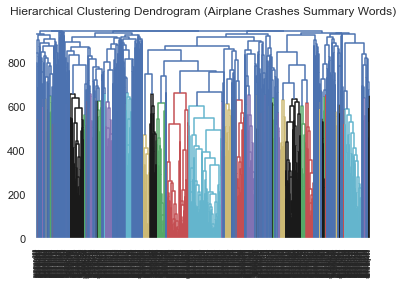

<Figure size 1440x1440 with 0 Axes>

In [143]:
plt.title('Hierarchical Clustering Dendrogram (Airplane Crashes Summary Words)')
plot_dendrogram(model,labels=clean_plane_new.index.values)
plt.xticks(rotation=90)
plt.savefig('airplanewords.pdf',format='pdf')
plt.figure(figsize=(20, 20))
plt.show()

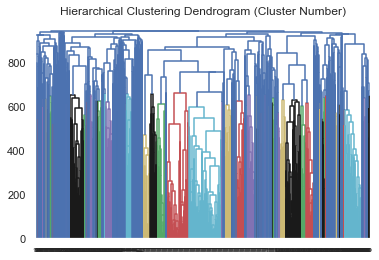

<Figure size 1440x1440 with 0 Axes>

In [144]:
plt.title('Hierarchical Clustering Dendrogram (Cluster Number)')
plot_dendrogram(model,labels=model.labels_)
plt.xticks(rotation=0)
plt.figure(figsize=(20, 20))
plt.show()

From the hierarchical clustering performed above, it is very difficult to interpret the results as the dendograms obtained are highly crowded and dense. I believe this is mostly because the data is very large and hence a lot of crowding is seen on the x-axis. 

In [18]:
kmeans = KMeans(n_clusters=21) # start with 3 clusters
kmeans.fit(clean_plane_new)
print("Labels:")
print(kmeans.labels_)

Labels:
[13 18  9  9  8  8 18  9 18 13 18 20  8 18 18 18 13  8 11 18  6 18 13  7
  6  8 18 20  9 20  8 13 18 13 18 20  8 20  8 18 13  8 18  8  8 18  8  8
 18  8 13 13 13 20 18  7  1 20  1  7 13 18  8 20 20 13 20 18 13 18  1 18
 18 20 18 18  6 15 13  8  7 20  1  8 13  1 13  8  1 18 20 20 18  6 20  1
 18  8  6  8  1  1 20  8  9 18 20  8 18 18  1 20 13 13  8 18  1  6  9  8
 11 13  9  8  8  8  8  8 18 20 18  1  8 20  8  8  8  1  1 18  8 18 11 20
  8  1 18 18 18 18  1  6 13 13 20  6  1 18  6  1  8 20 13 18 18 18 18  1
 13  1  8  8 20 18 20 20 18 18 18  8 18 18  2  8 20 18 18  1  1  8  6 18
  1 18 18  8  1  9  0  1  8 20  1  8  6 13  8  7 18 18  8 13 18 18  3 18
 20 20 18 18  8  8 18  8  8 18  7 11 11  8 20 18 18  8 18 18 20  6  8  8
 18  1 11 18  1 18 20  8  8 18 13 18 18 18 18  8  1 20 18  1 18 18  8 18
 18 20 18 13 20  1  1 18 18  0  9  1 18  8 18  8 18 13  8 20 18 18  8 18
 18  8  8  8 13 11 18 11  1  8  1  8  1  9 18 18  8  9  9 18 18 18 18 13
 20  8  1  8 20 18 13 18 18 18 20 18 18 20 

In [146]:
kmeans = KMeans(n_clusters=5) # move to 5 clusters
kmeans.fit(clean_plane_new)
print("Labels:")
print(kmeans.labels_)

Labels:
[1 1 1 1 3 3 1 1 1 1 1 2 3 1 1 1 1 3 4 1 1 1 1 3 3 3 1 2 1 2 3 1 1 1 1 2 3
 2 3 1 1 3 1 3 3 1 3 3 1 3 1 1 1 2 1 3 0 2 0 3 1 1 3 2 2 1 2 1 1 1 0 1 1 2
 1 1 3 4 1 3 3 2 0 3 1 0 3 3 0 1 2 2 1 3 2 0 1 3 3 3 0 0 2 3 1 1 2 3 1 1 0
 2 1 1 3 1 0 3 1 3 4 1 1 3 3 3 3 3 1 2 1 0 3 2 3 3 3 0 0 1 3 1 4 2 3 0 1 1
 1 1 0 3 1 1 2 3 0 1 3 0 3 2 1 1 1 1 1 0 1 0 3 3 2 1 2 2 1 1 1 3 1 1 4 3 2
 1 1 0 0 3 3 1 0 1 1 3 0 1 3 0 3 2 0 3 3 1 3 3 1 1 3 1 1 1 4 1 2 2 1 1 3 3
 1 3 3 1 3 4 4 3 2 1 1 3 1 1 2 3 3 3 1 0 4 1 0 1 2 3 3 1 1 1 1 1 1 3 0 2 1
 0 1 1 3 1 1 2 1 1 2 0 0 1 1 3 1 0 1 3 1 3 1 1 3 2 1 1 3 1 1 3 3 3 1 4 1 4
 0 3 0 3 0 1 1 1 3 1 1 1 1 1 1 1 2 3 0 3 2 1 1 1 1 1 2 1 1 2 2 0 3 1 2 1 1
 3 3 2 3 0 1 0 4 2 1 1 2 0 3 1 2 0 0 3 1 3 2 3 1 2 1 1 1 1 1 1 4 0 3 2 2 3
 4 0 2 4 1 2 3 3 2 2 1 2 2 1 1 4 0 1 0 1 2 1 3 2 1 1 1 1 1 1 4 2 4 3 1 1 1
 3 3 0 1 2 3 1 1 3 1 1 0 3 4 2 3 1 0 0 1 3 0 2 0 2 0 2 1 2 2 1 3 1 2 1 0 1
 2 0 3 1 2 1 3 3 3 4 2 4 2 3 4 1 1 1 3 1 3 3 0 0 3 1 1 2 1 1 3 0 1 3 3 1 1
 0 2 3 1 1 0 3 2 

In [147]:
clean_plane_newc = clean_plane_new.copy()

In [19]:
np.sqrt(len(clean_plane_new)/2) #rule of thumb

21.72556098240043

ValueError: num must be 1 <= num <= 8, not 9

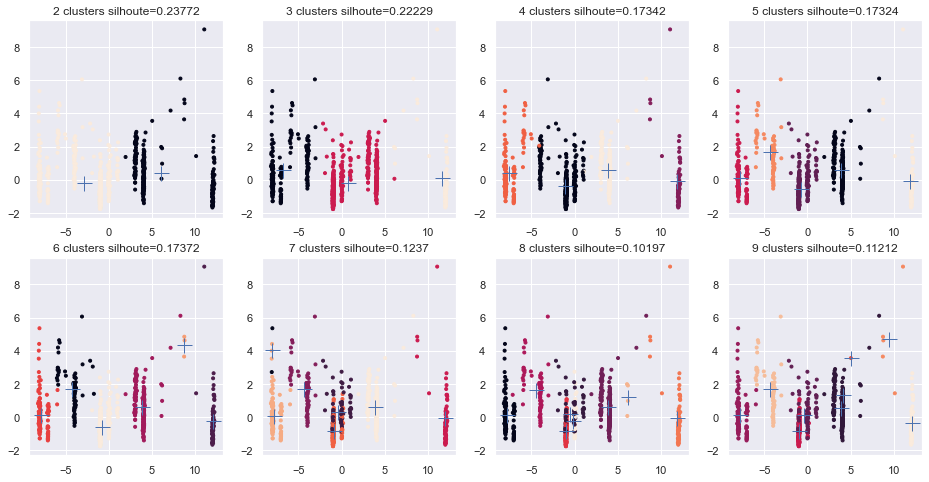

In [20]:
pca = PCA(n_components=2).fit(clean_plane_new)
airplane_df = pca.transform(clean_plane_new)

plt.figure(figsize=(16, 8))
scores, n_clusters, preds = [], [], []
for i in range(2, 22):
    kmean = KMeans(n_clusters = i).fit(clean_plane_new)
    scores.append(kmean.score(clean_plane_new))
    n_clusters.append(i)
    pred = kmean.predict(clean_plane_new)
    preds.append(pred)
    plt.subplot(2, 4, i - 1)
    plt.title(f"{i} clusters silhoute={np.round(silhouette_score(clean_plane_new, pred), decimals=5)}")
    plt.scatter(airplane_df[:, 0], airplane_df[:, 1], c=pred, marker = '.')
    
    airplane_centroids = kmean.cluster_centers_
    airplane_centroids2d = pca.transform(airplane_centroids)
    plt.plot(airplane_centroids2d[:, 0], airplane_centroids2d[:, 1], 'b+', markersize=15)

(1.0, 21.95)

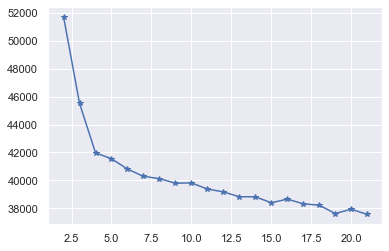

In [150]:
#elbow method
text = []
for k in range(2,25):
    k_means = KMeans(init='k-means++', n_clusters=k, n_init=10)
    k_means.fit(clean_plane_newc)
    text.append(k_means.inertia_)

fig, ax = plt.subplots()
plt.plot(range(2,25), text, 'b*-')
plt.xlim(1, plt.xlim()[1])

(1.0, 21.95)

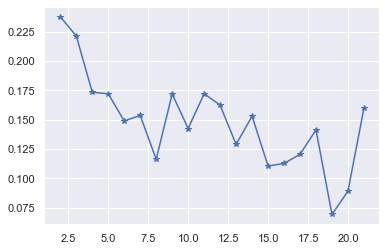

In [151]:
#silhouette method
text = []
for k in range(2,25):
    k_means = KMeans(init='k-means++', n_clusters=k, n_init=10)
    k_means.fit(clean_plane_newc)
    text.append(metrics.silhouette_score(clean_plane_newc, k_means.labels_))

# kIdx = np.argmax(cost)
fig, ax = plt.subplots()
plt.plot(range(2,25), text, 'b*-')
plt.xlim(1, plt.xlim()[1])


First I divided the data with number of clusters being 3 as that is the basic approach for k-means clustering. I then applied the rule of thumb to obtain the k-value which turns out to be 22. Elbow method gives an idea on what a good k number of clusters would be based on the sum of squared distance (SSE) between data points. We pick k at the spot where SSE starts to flatten out and forming an elbow. Given the range of value of k between 2-22 the k value for the airplane crashes data is obtained as 5. Silhouette analysis is used to determine the degree of separation between clusters i.e; to determine the similarity between the clusters.We therefore compute the average distance from all data points in the same cluster and the average distance from all data points in the closest cluster. If the coefficient is 0 the sample is very close to the neighbouring clusters and if it is 1 then it far away from the neighbouring clusters. Since the majority of the clusters/ data points are close to 0 (seen on y-axis) hence the sample is very close to the neighbouring clusters. 

In [152]:
plane_sample = clean_plane_new.iloc[100:115]
plane_sample

,adverse,altitude,angeles,back,burned,cause,conditions,control,crashed,due,...,preliminary,selecting,narita,gergaji,mulia,cindacta,janeiro-galeao,lt,utc,cluster
summary101,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,20
summary102,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,20
summary103,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
summary104,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,12
summary105,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,8
summary106,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,7
summary107,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
summary108,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,12
summary109,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,7
summary110,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,7


In [153]:
model_new = AgglomerativeClustering(n_clusters=5) # we can make up the value for clusters
model_new.fit_predict(plane_sample)
plane_sample['cluster'] = model_new.labels_

C:\Users\tabas\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


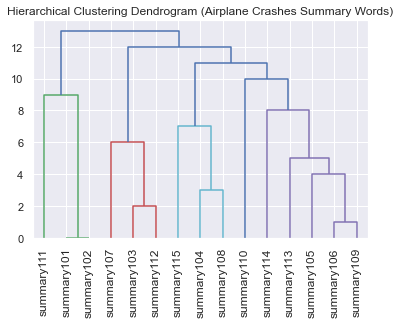

<Figure size 1440x1080 with 0 Axes>

In [154]:
plt.title('Hierarchical Clustering Dendrogram (Airplane Crashes Summary Words)')
plot_dendrogram(model_new,labels=plane_sample.index.values)
plt.xticks(rotation=90)
plt.savefig('airplanewords.pdf',format='pdf')
plt.figure(figsize=(20, 15))
plt.show()

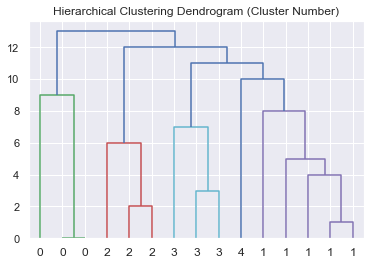

<Figure size 1440x1080 with 0 Axes>

In [155]:
plt.title('Hierarchical Clustering Dendrogram (Cluster Number)')
plot_dendrogram(model_new,labels=model_new.labels_)
plt.xticks(rotation=0)
plt.figure(figsize=(20, 15))
plt.show()

# Q5 (20 pts): Explain your clustering results
- How can you explain your clustering results? What kind of summaries are included in each cluster?
- Could you select some representative examples for each cluster?
- Word cloud, which has been used in the last assignment, may be helpful for understanding the clustering results

From the clustering results obtained from the above plane_sample I understand that the y-axis is a measure of closeness of either individual data points or clusters. In the final dendrogram of the above question, the height of the dendrogram reflect the distance between the clusters. I chose a sample of 15 data poingts in order to appreaciate the closeness of the clusters with each other. Summary110 and Summary111 are more closely related as compared to Summary110 and Summary103. The cluster number dendogram shows the degree of similiarity between each of the 5 clusters in the dataframe. The cluster 4 and 0 are more closely related as compared to cluster 4 and 2.

According to my understanding of the clustering results, I believe the summaries having majority of meaningful words in common are included in one cluster.

In [156]:
airplane_cloud = df_plane_clean.copy()
airplane_cloud = pd.DataFrame(airplane_cloud['Summary'])
airplane_cloud.rename(columns = {'Summary': 'summary'}, inplace = True)
airplane_cloud

,summary
208,"While en route to Los Angeles, the pilot, flyi..."
236,"Shortly after taking off from Kansas City, one..."
334,The plane crashed about 11 miles from St. Jose...
354,The plane crashed while en route from Albuquer...
365,Crashed 3 miles south of Gilmer. The outboard ...
...,...
5248,The commuter plane crashed while attemptiong t...
5251,The plane was on final approach to Runway 18R ...
5255,The cargo plane crashed and burst into flame a...
5259,The passenger plane crashed in poor weather in...


In [157]:
airplane_cloud['summary'] = airplane_cloud['summary'].str.lower().str.replace("[$&+,:;=?@#|'<>.-^*{}()%!]",'')
airplane_cloud

,summary
208,while en route to los angeles the pilot flying...
236,shortly after taking off from kansas city one ...
334,the plane crashed about miles from st joseph ...
354,the plane crashed while en route from albuquer...
365,crashed miles south of gilmer the outboard en...
...,...
5248,the commuter plane crashed while attemptiong t...
5251,the plane was on final approach to runway r wh...
5255,the cargo plane crashed and burst into flame a...
5259,the passenger plane crashed in poor weather in...


In [158]:
# from cluster 0
sum101 = airplane_cloud.iloc[100:101]
sum101

,summary
1088,the pilot failed to follow the carriers prescr...


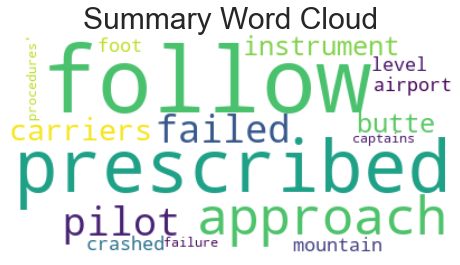

In [159]:
summ_cl0 = str(sum101.summary.tolist())

stop = set(stopwords.words('english'))

airplane_word_cloud = WordCloud(background_color="white", max_words=6000, stopwords=stop)
airplane_word_cloud.generate(summ_cl0)

plt.figure(figsize=(8,6))
plt.imshow(airplane_word_cloud, interpolation='bilinear')
plt.axis("off")
plt.title('Summary Word Cloud', loc='Center', fontsize=30)
plt.savefig('airplane_word_cloud.png', dpi=50)

In [160]:
# from cluster 1
sum108 = airplane_cloud.iloc[107:108]
sum108

,summary
1125,the aircraft crashed after being caught in a s...


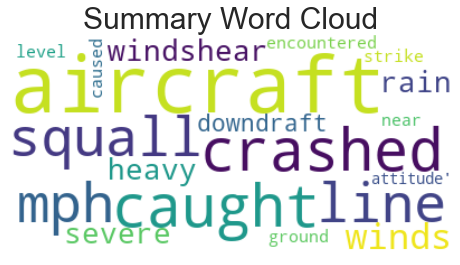

In [161]:
summ_cl1 = str(sum108.summary.tolist())

stop = set(stopwords.words('english'))

airplane_word_cloud = WordCloud(background_color="white", max_words=6000, stopwords=stop)
airplane_word_cloud.generate(summ_cl1)

plt.figure(figsize=(8,6))
plt.imshow(airplane_word_cloud, interpolation='bilinear')
plt.axis("off")
plt.title('Summary Word Cloud', loc='Center', fontsize=30)
plt.savefig('airplane_word_cloud.png', dpi=50)

In [162]:
# from cluster 2
sum112 = airplane_cloud.iloc[111:112]
sum112

,summary
1159,crashed while attempting to land at albuquerqu...


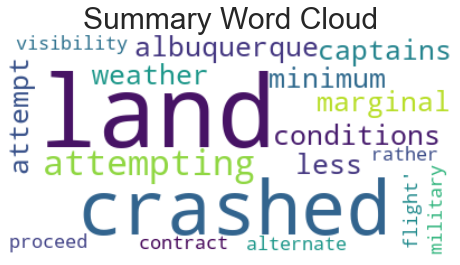

In [163]:
summ_cl2 = str(sum112.summary.tolist())

stop = set(stopwords.words('english'))

airplane_word_cloud = WordCloud(background_color="white", max_words=6000, stopwords=stop)
airplane_word_cloud.generate(summ_cl2)

plt.figure(figsize=(8,6))
plt.imshow(airplane_word_cloud, interpolation='bilinear')
plt.axis("off")
plt.title('Summary Word Cloud', loc='Center', fontsize=30)
plt.savefig('airplane_word_cloud.png', dpi=50)

In [164]:
# from cluster 3
sum106 = airplane_cloud.iloc[105:106]
sum106

,summary
1121,the plane crashed into the north slope of sant...


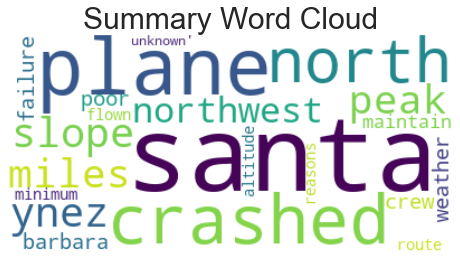

In [165]:
summ_cl3 = str(sum106.summary.tolist())

stop = set(stopwords.words('english'))

airplane_word_cloud = WordCloud(background_color="white", max_words=6000, stopwords=stop)
airplane_word_cloud.generate(summ_cl3)

plt.figure(figsize=(8,6))
plt.imshow(airplane_word_cloud, interpolation='bilinear')
plt.axis("off")
plt.title('Summary Word Cloud', loc='Center', fontsize=30)
plt.savefig('airplane_word_cloud.png', dpi=50)

In [166]:
# for cluster 4
sum110 = airplane_cloud.iloc[109:110]
sum110

,summary
1134,en route from san francisco to denver after pa...


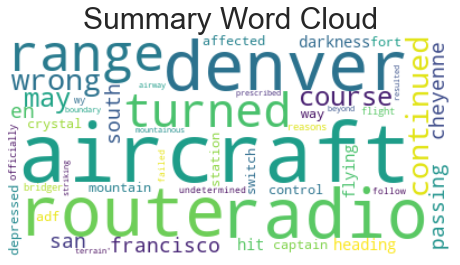

In [167]:
summ_cl4 = str(sum110.summary.tolist())

stop = set(stopwords.words('english'))

airplane_word_cloud = WordCloud(background_color="white", max_words=6000, stopwords=stop)
airplane_word_cloud.generate(summ_cl4)

plt.figure(figsize=(8,6))
plt.imshow(airplane_word_cloud, interpolation='bilinear')
plt.axis("off")
plt.title('Summary Word Cloud', loc='Center', fontsize=30)
plt.savefig('airplane_word_cloud.png', dpi=50)

The words most commonly repeated in the cluster 0 representative are: "follow", "prescribed", "carriers" and "approach".

The words most commonly repeated in the cluster 1 representative are: "aircraft", "crashed", "caught", "line" and "winds".

The words most commonly repeated in the cluster 2 representative are: "land", "crashed" and "attempting".

The words most commonly repeated in the cluster 3 representative are: "santa", "crashed", "plane" and "north".

The words most commonly repeated in the cluster 4 representative are: "aircraft", "denver", "router", "adio" and "range".

We can observe that cluster 1, 2 and 3 have the word "crashed" in common hence show similarity cluster 0 and cluster 4 seem to display differences. We can also observe that some words that are most commonly repeated in one cluster are less commonly repeated in the other hence those clusters show lower degree of similarities.

# Q5 (5 pts): Reflect on your thoughts
When you completes the clustering, please look back to your original plan for the clustering. 
- Within your plan, which steps are actually taken eventually? Which are not?  What modifications did you make to your planned process?
- Are the clustering results different from your expectations? Did you find anything unexpected or surprising?

I had performed all the steps within my roadmap plan. I did made some modifications like choosing a small sample from the original data as the dendograms were highly crowded and impossible to interpret.

Honestly, I wasn't expecting that data clusters to show such satisfactory degree of similarities at the same time I didn't assume them to be absolutely different. It was interesting to know that words like "crashed", "aircraft", "route" are most commonly repeated. I was surprised to see the densely populated dendograms and were just impossible to interpret.

Worked on this notebook with Roberto Guzman, Tanvi Shah and David Josue Molina.